In [1]:
import os
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.io import fits
from xai import read_data, create_dataframe, compare_experiments, compare_exp_testset
from xai import plot_true_fake_maps, plot_sample_r_vs_k, plot_r_vs_r, plot_all_r_vs_k, plot_r_single_sample
#from xai import read_data, create_dataframe, plot_true_fake_maps


/usr/local/lib/python3.6/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [9]:
base_output_dir = "../output/" # Meanwhile I have my own output directory with GAN results
names = ['test', 'xai_exp_only_using_random', 
         'xai_exp_only_using_random', 'xai_exp_only_using_random_oiii' ]
results_dir = "../output/xai_results/"
nrun = 100
nindex = 1
suffix_list = [ "run{:d}_index{:d}".format(i, j) for i in range(nrun) for j in range(nindex) ]
ref_dir = os.path.join(base_output_dir, names[0])
exp1_dir = os.path.join(base_output_dir, names[1])
exp2_dir = os.path.join(base_output_dir, names[2])
exp3_dir = os.path.join(base_output_dir, names[3])

In [105]:
def read_shuffeled_data(output_dir, suffix=f"run0_index0"):
    f_realA = f"/mnt/data_cat4/moriwaki/IM2IM/val_data/{suffix}_z1.3_ha.fits"
    f_realB = f"/mnt/data_cat4/moriwaki/IM2IM//val_data/{suffix}_z2.0_oiii.fits"
    f_fakeA = f"{output_dir}/gen_{suffix}_0.fits"
    f_fakeB = f"{output_dir}/gen_{suffix}_1.fits"
    f_pertA = f"{output_dir}/shuffled_input_{suffix}_target_0.fits"
    f_pertB = f"{output_dir}/shuffled_input_{suffix}_target_1.fits"
    f_pertC = f"{output_dir}/shuffled_input_{suffix}_source.fits"
    
    # Construct lists for opening the files
    f_real = [ f_realA, f_realB ]
    f_fake = [ f_fakeA, f_fakeB ]
    f_pert = [ f_pertC, f_pertA, f_pertB ]
    # Open the files and construct a data list and corresponding keys
    raw_r  = [ fits.open( f )[0].data for f in f_real ]
    data_r = [ raw_r[0]+raw_r[1], raw_r[0], raw_r[1] ]
    keys_r = ['obs', 'realA', 'realB']
    raw_f  = [ fits.open( f )[0].data for f in f_fake ]
    data_f = [ raw_f[0]+raw_f[1], raw_f[0], raw_f[1] ]
    keys_f = ['rec', 'fakeA', 'fakeB']
    data_p = [ fits.open( f )[0].data for f in f_pert ]
    keys_p = ['p_s', 'p_tA', 'p_tB'] # p_s: perturbed source, p_t: perturbed target
    # Create dictionaries with keys and data
    dict_r = dict(zip(keys_r, data_r))
    dict_f = dict(zip(keys_f, data_f))
    dict_p = dict(zip(keys_p, data_p))
    # Convert to pandas dataframes
    df_r = pd.DataFrame.from_dict({k: [v] for k, v in dict_r.items()})
    df_f = pd.DataFrame.from_dict({k: [v] for k, v in dict_f.items()})
    df_p = pd.DataFrame.from_dict({k: [v] for k, v in dict_p.items()})
    # Concatenate all into one dataframe
    df = pd.concat([df_r, df_p, df_f], axis=1)
    
    return df
    

In [107]:
def plot_shuffled_map(df, results_dir):
    vmin = 0
    vmax = 9.0e-08
    _, axs = plt.subplots(3,3)
    col = df.columns
    for i in range(len(col)):
        ax = axs[int(i/3)][int(i%3)]
        ax.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
        ax.set_title(col[i])
        ax.imshow(df[col[i]].values[0], interpolation="none", vmin=vmin, vmax=vmax)

In [106]:
df = read_shuffeled_data(exp1_dir)

In [108]:
df.columns

Index(['obs', 'realA', 'realB', 'p_s', 'p_tA', 'p_tB', 'rec', 'fakeA',
       'fakeB'],
      dtype='object')

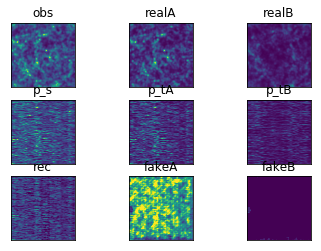

In [109]:
plot_shuffled_map(df, results_dir)

,obs,realA,realB,rec,fakeA,fakeB,p_s,p_t1,p_t2
0,"[[3.219330782338235e-08, 2.8971048269429372e-0...","[[2.4782103767371394e-08, 2.1227870145433785e-...","[[7.411204056010957e-09, 7.743178123995586e-09...","[[1.541035e-08, 8.26148e-09, 2.5434144e-08, 1....","[[4.9540617e-08, 3.675672e-08, 4.4748997e-08, ...","[[-3.4130267e-08, -2.849524e-08, -1.9314854e-0...","[[8.075383e-09, 8.388948e-09, 8.815285e-09, 9....","[[6.55325e-10, 7.671956e-10, 9.593242e-10, 1.2...","[[8.730708e-09, 9.156143e-09, 9.77461e-09, 1.0..."


In [61]:
test = read_shuffeled_data(exp1_dir)
print(len(test))
test['obs'].values[0].shape

1


(256, 256)

In [45]:
pd.DataFrame.from_dict({k: [v] for k, v in test.items()})

,p_source,p_t1,p_t2
0,"[[8.075383e-09, 8.388948e-09, 8.815285e-09, 9....","[[6.55325e-10, 7.671956e-10, 9.593242e-10, 1.2...","[[8.730708e-09, 9.156143e-09, 9.77461e-09, 1.0..."


In [20]:
s_r = pd.Series(test, name='orignal')

In [23]:
np.shape(s_r[0])

(256, 256)

In [43]:
import pandas as pd
import numpy as np

# Example dictionary with NumPy arrays
data_dict = {'A': np.random.rand(256, 256),
             'B': np.random.rand(256, 256),
             'C': np.random.rand(256, 256),
             'D': np.random.rand(256, 256),
             'E': np.random.rand(256, 256)}

# Convert dictionary to DataFrame
df = pd.DataFrame.from_dict({k: [v] for k, v in data_dict.items()})



In [44]:
df

,A,B,C,D,E
0,"[[0.15150246458496897, 0.7176556803244578, 0.7...","[[0.774577632048928, 0.5111136736779874, 0.992...","[[0.5693477878381359, 0.05520668393112105, 0.9...","[[0.2103915851351441, 0.7411252995507601, 0.60...","[[0.32096959576819506, 0.8550433366840703, 0.9..."
